In [17]:
from ground_functions import *
import multiprocess as mp
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [18]:
nprocs = mp.cpu_count()
pool = mp.Pool(processes=nprocs)

def find_sol(rparams):
    ri, rf, dr = rparams
    steps = int((rf - ri)//dr)
    
    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    count, step_stdev, nneighboors = 0, 1, nprocs
    for i in np.arange(nsteps):
        # Give a random kick to phi0
        phi0old = phi0
        allphi0s = np.array([phi0]*nneighboors) + np.random.normal(0,step_stdev,nneighboors)

        mcs = pool.starmap(mc_step, [(phi0here, bpoint, rparams) for phi0here in allphi0s])
        bpoints = np.array([mc[1] for mc in mcs])
        bpoint_max = np.amax(bpoints)
        index_max = np.where(bpoints == bpoint_max)[0]

        if bpoint_max > bpoint:  # If a larger 'bpoint' is found, keep
            bpoint = bpoint_max
            phi0 = allphi0s[index_max][0]
        else:   # If not, back to old valur of phi0
            count += 1
        
        # Variable 'count' avoids the code 'getting stuck' for large periods of time, makes step smaller when it happens
        if count > 2:
            count = 0
            step_stdev = step_stdev/10

        # If the solution does not break in the interval or step is too small, stop
        if bpoint == steps - 1 or step_stdev < 1e-20:
            return phi0, bpoint

    return phi0, bpoint

The value of epsilonb is: 0.6939841449451077
The value of tilde phi0 is: -0.6494301842346241


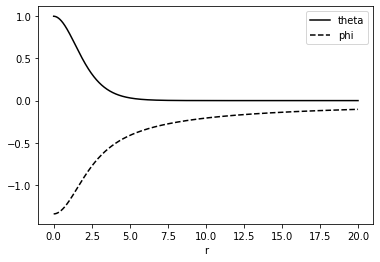

In [19]:
# Plotting solution
rparams = 0, 20, 0.01 # rparams in the format ri, rf, dr
ri, rf, dr = rparams
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

phi0_plt = find_sol(rparams)[0]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint = rk4(Xbc_plt, rparams)
rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
print('The value of epsilonb is:', epsilonb)
print('The value of tilde phi0 is:', Xs[2].T[0])

plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
plt.xlabel("r")
plt.legend();